In [2]:
%matplotlib inline
import pylab as plt
from blimpy import Waterfall
import numpy as np
from scipy import interpolate
import peakutils
import rfi
import turbo_seti
import pandas as pd
import BaselineRemoval
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import scipy
import os
from astropy.time import Time
from astropy import units as u
import matplotlib

In [3]:
def time(w):
    for key, val in w.file_header.items():
        if key == 'src_raj':
            val = val.to_string(unit=u.hour, sep=':')
        if key == 'src_dej':
            val = val.to_string(unit=u.deg, sep=':')
        if key in ('foff', 'fch1'):
            val *= u.MHz
        if key == 'tstart':
            #print("%16s : %32s" % ("tstart (ISOT)", Time(val, format='mjd').isot))
            key = "tstart (MJD)"
            return  Time(val, format='mjd').isot

In [4]:
path='data/SR/'
files=os.listdir(path)
#files.remove('.ipynb_checkpoints')
len(files)

32

In [5]:
wf=[]
j=0
for i in files:
    #print(j)
    wf.append(Waterfall(path+i))
    j+=1
name=[]
j=0
for i in wf:
    name.append([i.container.f_start,files[j]])
    j+=1
name.sort(reverse=True)
wf=[]
for i in name:
    wf.append(Waterfall(path+i[1]))

1284.0
1284.0
1284.0
1284.0
952.0
952.0
952.0
952.0
952.0
952.0
952.0
952.0
952.0
856.0
856.0
856.0
856.0
856.0
856.0
856.0
856.0
856.0
856.0
856.0
816.0
816.0
816.0
680.0
680.0
544.0
544.0
544.0


In [20]:
for i in wf:
    print(i.container.f_start,i.container.f_stop)

1284.0 1498.0
1284.0 1471.25
1284.0 1498.0
1284.0 1471.25
952.0 1088.0
952.0 1088.0
952.0 1088.0
952.0 1088.0
952.0 1088.0
952.0 1088.0
952.0 1088.0
952.0 1088.0
952.0 1088.0
856.0 1043.25
856.0 1070.0
856.0 1070.0
856.0 1043.25
856.0 1016.5
856.0 1043.25
856.0 1016.5
856.0 1043.25
856.0 1016.5
856.0 1016.5
856.0 1070.0
816.0 952.0
816.0 952.0
816.0 952.0
680.0 816.0
680.0 816.0
544.0 680.0
544.0 680.0
544.0 680.0


In [14]:
j=0
for i in wf:
    if i.container.f_start==856.0:
        j+=1
print(j)

11


In [6]:
data=pd.DataFrame()
data['source_name']=[]
data['time(MJD)']=[]
data['src_raj']=[]
data['f_range(MHz)']=[]
data['RFI(MHz)']=[]
j=0
for i in wf:
    a=i.header['source_name']
    b=i.header['tstart']
    c=i.header['src_raj']
    d=(i.container.f_begin,i.container.f_end)
    e=rfi.rfi_range(i,dist=50)
    data.loc[j]=[a,b,c,d,e]
    j+=1
    #print(j)
data.to_latex('RFI_SR.tex',index=False)
data.to_csv('RFI_SR.csv',index=False)

WARING max iteration reached!


In [7]:
a=0
b=0
c=0
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>880)&(j[0]<970)) or ((j[1]>880)&(j[1]<970)):
            a+=1
            break
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>1120)&(j[0]<1300)) or ((j[1]>1120)&(j[1]<1300)):
            b+=1
            break
for i in data['RFI(MHz)']:
    for j in i:
        if ((j[0]>1400)&(j[0]<1610)) or ((j[1]>1400)&(j[1]<1610)):
            c+=1
            break
print(a,b,c)

22 4 4


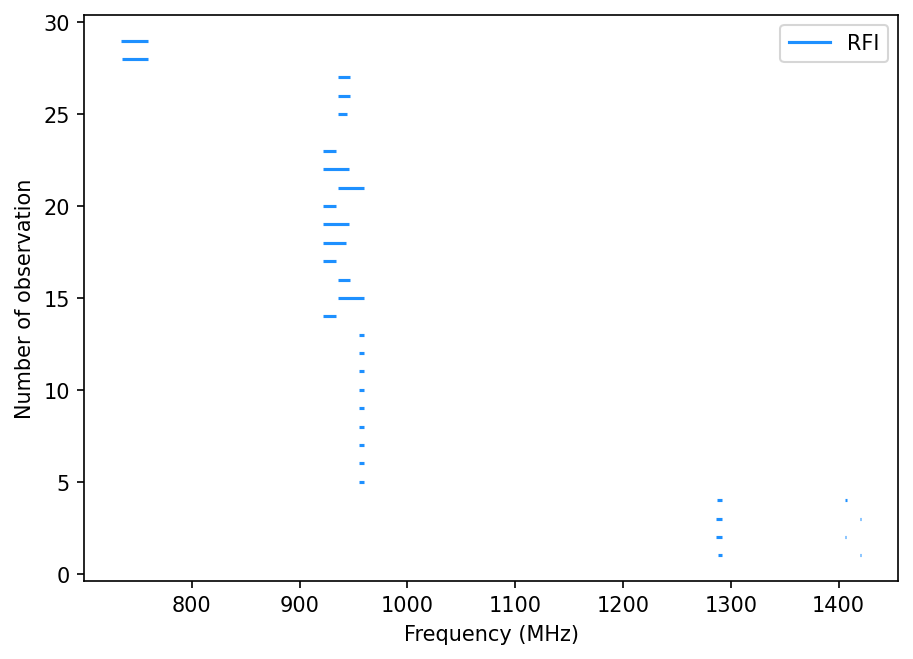

In [8]:
j=1
plt.figure(figsize=(7,5),dpi=150)
for i in data['RFI(MHz)']:
    for k in i:
        plt.hlines(j,k[0],k[1],color='dodgerblue')
    j+=1
plt.plot([],[],color='dodgerblue',label='RFI')
# plt.vlines(880,0,50,'dodgerblue',linestyles='--')
# plt.vlines(960,0,50,'dodgerblue',linestyles='--')
# plt.vlines(1120,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1300,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1400,0,28,'dodgerblue',linestyles='--')
# plt.vlines(1610,0,28,'dodgerblue',linestyles='--')
# plt.bar(700,50,width=312,color='w',hatch='/',label='UHF-band')
# plt.bar(972,50,width=232,color='w',hatch='X',label='UHF and L overlap')
# plt.bar(1400,50,width=624,color='w',hatch="\\",label='L-band')
# plt.text(900,50,str(a)+' obs')
# plt.text(1190,28,str(b)+' obs')
# plt.text(1490,28,str(c)+' obs')
plt.ylabel('Number of observation')
plt.xlabel('Frequency (MHz)')
plt.legend()
plt.savefig('plots/after_mid/RFI_vs_File_SR.pdf')

In [38]:
j=1
fig1=plt.figure(figsize=(10,4*4),dpi=100)
for i in wf[:4]:
    if i.container.f_start==(856.0 or 544.0): #remove the first index for a better fitting
        f=i.get_power()[0][1:]
        p=i.get_power()[1][1:]
    else:
        f=i.get_power()[0]
        p=i.get_power()[1]
    #Different situation:
    plt.subplot(4,1,j)
    snr=p.mean()/p.std()
    if snr>15:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>6:
        r,base=rfi.peakbase(f,p)
        p=r
        rm=r-base
    elif snr>3:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>1.6:
        r,base=rfi.peakbase(f,p,deg=6)
        p=r
        rm=r-base
    else:
        r,base=rfi.peakbase(f,p,deg=10)
        p=r
        rm=r-base
    #print(np.amax(p))
    maxi=np.amax(rm)
    multi=2.5
    if maxi>10000:
        multi=multi/10
    thres=multi*rm.std()
    plt.plot(f,base+thres,label='Threshold')
    index_1=np.where((f>=544.0)&(f<=650.0))
    index_2=np.where((f>=856.0)&(f<=920.0))
    index_3=np.where((f>=960.0)&(f<=1088.0))
    index_4=np.where((f>=1650.0)&(f<=1712.0))
    p[index_1]=base[index_1]
    if i.container.f_start==856.0:
        p[index_2]=base[index_2]
    if np.round(i.container.f_stop,decimals=1)==1088.0:
        p[index_3]=base[index_3]
    p[index_4]=base[index_4]
    #plotting
    plt.plot(f,p,'k',label='Observed')
    plt.plot(f,base,'r--',label='Fitted')
    RFI=rfi.rfi_range(i,dist=10)
    tot=0
    for k in RFI:
        plt.bar((k[1]+k[0])/2,height=np.amax(p)-np.amin(base),color='lime',width=(k[1]-k[0]),bottom=np.amin(base))
        tot+=(k[1]-k[0])
#     plt.text(1128,np.amax(p)*0.9,
#              str(j)+'Identified RFI covers '+str(np.round(tot/(i.container.f_stop-i.container.f_start)*100,decimals=2))+'% of given bandwidth'
#              ,size=5,ha='center')
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(1284.0,1498.0)
    plt.text(1391,2000,'L-Band at '+time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    #plt.yscale('log')
    plt.legend()
        #plt.ylim(np.amin(base),np.amax(p))
    #     if j!=49:
    #         plt.xticks([])
    #     plt.subplots_adjust(hspace=0)
        #print(j)
    j+=1
plt.savefig('plots/after_mid/all_fitting_SR_1.pdf',bbox_inches = 'tight')
plt.close()

In [39]:
j=1
fig2=plt.figure(figsize=(10,4*9),dpi=100)
for i in wf[4:13]:
    if i.container.f_start==(856.0 or 544.0): #remove the first index for a better fitting
        f=i.get_power()[0][1:]
        p=i.get_power()[1][1:]
    else:
        f=i.get_power()[0]
        p=i.get_power()[1]
    #Different situation:
    plt.subplot(9,1,j)
    snr=p.mean()/p.std()
    if snr>15:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>6:
        r,base=rfi.peakbase(f,p)
        p=r
        rm=r-base
    elif snr>3:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>1.6:
        r,base=rfi.peakbase(f,p,deg=6)
        p=r
        rm=r-base
    else:
        r,base=rfi.peakbase(f,p,deg=10)
        p=r
        rm=r-base
    #print(np.amax(p))
    maxi=np.amax(rm)
    multi=2.5
    if maxi>10000:
        multi=multi/10
    thres=multi*rm.std()
    plt.plot(f,base+thres,label='Threshold')
    index_1=np.where((f>=544.0)&(f<=650.0))
    index_2=np.where((f>=856.0)&(f<=920.0))
    index_3=np.where((f>=960.0)&(f<=1088.0))
    index_4=np.where((f>=1650.0)&(f<=1712.0))
    p[index_1]=base[index_1]
    if i.container.f_start==856.0:
        p[index_2]=base[index_2]
    if np.round(i.container.f_stop,decimals=1)==1088.0:
        p[index_3]=base[index_3]
    p[index_4]=base[index_4]
    #plotting
    plt.plot(f,p,'k',label='Observed')
    plt.plot(f,base,'r--',label='Fitted')
    RFI=rfi.rfi_range(i,dist=10)
    tot=0
    for k in RFI:
        plt.bar((k[1]+k[0])/2,height=np.amax(p)-np.amin(base),color='lime',width=(k[1]-k[0]),bottom=np.amin(base))
        tot+=(k[1]-k[0])
#     plt.text(1128,np.amax(p)*0.9,
#              str(j)+'Identified RFI covers '+str(np.round(tot/(i.container.f_stop-i.container.f_start)*100,decimals=2))+'% of given bandwidth'
#              ,size=5,ha='center')
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(952.0,1088.0)
    plt.text(1020.0,2000,'L-Band at '+time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    #plt.yscale('log')
    plt.legend()
        #plt.ylim(np.amin(base),np.amax(p))
    #     if j!=49:
    #         plt.xticks([])
    #     plt.subplots_adjust(hspace=0)
        #print(j)
    j+=1
plt.savefig('plots/after_mid/all_fitting_SR_2.pdf',bbox_inches = 'tight')
plt.close()

In [40]:
j=1
fig3=plt.figure(figsize=(10,4*11),dpi=100)
for i in wf[13:24]:
    if i.container.f_start==(856.0 or 544.0): #remove the first index for a better fitting
        f=i.get_power()[0][1:]
        p=i.get_power()[1][1:]
    else:
        f=i.get_power()[0]
        p=i.get_power()[1]
    #Different situation:
    plt.subplot(11,1,j)
    snr=p.mean()/p.std()
    if snr>15:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>6:
        r,base=rfi.peakbase(f,p)
        p=r
        rm=r-base
    elif snr>3:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>1.6:
        r,base=rfi.peakbase(f,p,deg=6)
        p=r
        rm=r-base
    else:
        r,base=rfi.peakbase(f,p,deg=10)
        p=r
        rm=r-base
    #print(np.amax(p))
    maxi=np.amax(rm)
    multi=2.5
    if maxi>10000:
        multi=multi/10
    thres=multi*rm.std()
    plt.plot(f,base+thres,label='Threshold')
    index_1=np.where((f>=544.0)&(f<=650.0))
    index_2=np.where((f>=856.0)&(f<=920.0))
    index_3=np.where((f>=960.0)&(f<=1088.0))
    index_4=np.where((f>=1650.0)&(f<=1712.0))
    p[index_1]=base[index_1]
    if i.container.f_start==856.0:
        p[index_2]=base[index_2]
    if np.round(i.container.f_stop,decimals=1)==1088.0:
        p[index_3]=base[index_3]
    p[index_4]=base[index_4]
    #plotting
    plt.plot(f,p,'k',label='Observed')
    plt.plot(f,base,'r--',label='Fitted')
    RFI=rfi.rfi_range(i,dist=10)
    tot=0
    for k in RFI:
        plt.bar((k[1]+k[0])/2,height=np.amax(p)-np.amin(base),color='lime',width=(k[1]-k[0]),bottom=np.amin(base))
        tot+=(k[1]-k[0])
#     plt.text(1128,np.amax(p)*0.9,
#              str(j)+'Identified RFI covers '+str(np.round(tot/(i.container.f_stop-i.container.f_start)*100,decimals=2))+'% of given bandwidth'
#              ,size=5,ha='center')
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(856.0,1070.0)
    plt.text(963.0,np.amax(p)*0.1,'L-Band at '+time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
    if j!=11:
        plt.ylim(-100,np.amax(p)*0.1)
    #plt.yscale('log')
    plt.legend()
    j+=1
plt.savefig('plots/after_mid/all_fitting_SR_3.pdf',bbox_inches = 'tight')
plt.close()

WARING max iteration reached!
WARING max iteration reached!


In [41]:
j=1
fig4=plt.figure(figsize=(10,4*8),dpi=100)
for i in wf[24:]:
    if i.container.f_start==(856.0 or 544.0): #remove the first index for a better fitting
        f=i.get_power()[0][1:]
        p=i.get_power()[1][1:]
    else:
        f=i.get_power()[0]
        p=i.get_power()[1]
    #Different situation:
    plt.subplot(8,1,j)
    snr=p.mean()/p.std()
    if snr>15:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>6:
        r,base=rfi.peakbase(f,p)
        p=r
        rm=r-base
    elif snr>3:
        base=rfi.splbase(f,p)
        rm=p-base
    elif snr>1.6:
        r,base=rfi.peakbase(f,p,deg=6)
        p=r
        rm=r-base
    else:
        r,base=rfi.peakbase(f,p,deg=10)
        p=r
        rm=r-base
    #print(np.amax(p))
    maxi=np.amax(rm)
    multi=2.5
    if maxi>10000:
        multi=multi/10
    thres=multi*rm.std()
    plt.plot(f,base+thres,label='Threshold')
    index_1=np.where((f>=544.0)&(f<=650.0))
    index_2=np.where((f>=856.0)&(f<=920.0))
    index_3=np.where((f>=960.0)&(f<=1088.0))
    index_4=np.where((f>=1650.0)&(f<=1712.0))
    p[index_1]=base[index_1]
    if i.container.f_start==856.0:
        p[index_2]=base[index_2]
    if np.round(i.container.f_stop,decimals=1)==1088.0:
        p[index_3]=base[index_3]
    p[index_4]=base[index_4]
    #plotting
    plt.plot(f,p,'k',label='Observed')
    plt.plot(f,base,'r--',label='Fitted')
    RFI=rfi.rfi_range(i,dist=10)
    tot=0
    for k in RFI:
        plt.bar((k[1]+k[0])/2,height=np.amax(p)-np.amin(base),color='lime',width=(k[1]-k[0]),bottom=np.amin(base))
        tot+=(k[1]-k[0])
#     plt.text(1128,np.amax(p)*0.9,
#              str(j)+'Identified RFI covers '+str(np.round(tot/(i.container.f_stop-i.container.f_start)*100,decimals=2))+'% of given bandwidth'
#              ,size=5,ha='center')
    plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(20))
    plt.grid()
    plt.grid(which='minor',color='whitesmoke')
    plt.xlim(544.0,952.0)
    plt.text(748,np.amax(p),'UHF-Band at '+time(i)+' from '+i.header['source_name'],size=5,ha='center',fontsize=10)
#     plt.ylim(ymax=)
    #plt.yscale('log')
    plt.legend()
    j+=1
plt.savefig('plots/after_mid/all_fitting_SR_4.pdf',bbox_inches = 'tight')
plt.close()

In [45]:
for i in wf:
    print(i.get_power()[1].mean()/i.get_power()[1].std())

13.832037
6.665604
6.075773
14.108901
1.6670731
1.6797107
1.6012288
1.6834681
1.6803585
1.692287
1.6827079
1.6863177
1.6831537
0.34967363
0.38748193
0.3559275
0.9542952
0.8871236
0.8031865
0.44247103
0.4515714
0.30148992
0.9369558
0.22241098
0.40273055
0.30928886
0.29347262
16.576675
25.754492
3.031362
3.0714831
3.0305967


extracting integration 0...


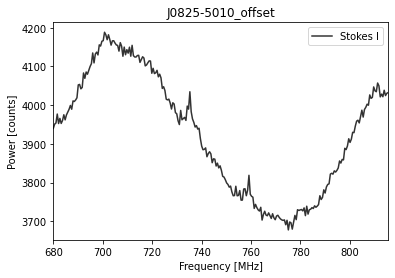

In [44]:
wf[-4].plot_spectrum()

extracting integration 0...


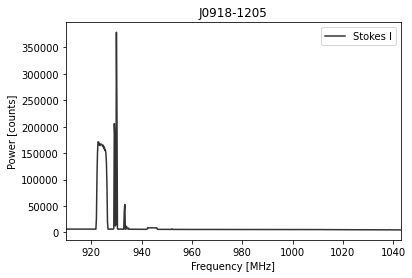

In [47]:
wf[13].plot_spectrum(f_start=910)

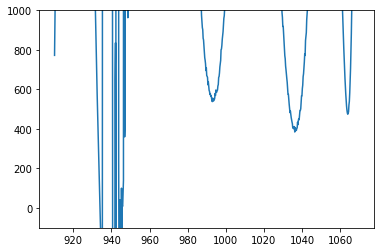

In [66]:
f=wf[14].get_power()[0]
p=wf[14].get_power()[1]
index=np.where(f>910)
f=f[index]
p=p[index]
rm=BaselineRemoval.BaselineRemoval(p).ZhangFit()
rm=np.where(rm<0,0,rm)
base=peakutils.baseline(rm,deg=10)
plt.ylim(-100,1000)
#plt.plot(f,p,f,base,'--')
plt.plot(f,rm-base)

In [67]:
f,p,base=rfi.base(wf[14])

ValueError: not enough values to unpack (expected 3, got 2)